In [3]:
import pandas as pd

# files
income_path = "/Users/dante/Documents/ACSST5Y2023.S1901_2026-02-04T152351/ACSST5Y2023.S1901-Data.csv"
pop_path = "/Users/dante/Documents/ACSDT5Y2023.B01003_2026-02-04T152632/ACSDT5Y2023.B01003-Data.csv"

# load
income_raw = pd.read_csv(income_path)
pop_raw = pd.read_csv(pop_path)


income = income_raw.iloc[1:].copy()
pop = pop_raw.iloc[1:].copy()


income = income[["GEO_ID", "NAME", "S1901_C01_012E"]]
income = income.rename(columns={
    "S1901_C01_012E": "median_household_income"
})

pop = pop[["GEO_ID", "NAME", "B01003_001E"]]
pop = pop.rename(columns={
    "B01003_001E": "population"
})

# conversions
income["median_household_income"] = pd.to_numeric(income["median_household_income"], errors="coerce")
pop["population"] = pd.to_numeric(pop["population"], errors="coerce")


print("Income shape:", income.shape)
print("Population shape:", pop.shape)

print("\nIncome preview:")
display(income.head())

print("\nPopulation preview:")
display(pop.head())


Income shape: (358, 3)
Population shape: (358, 3)

Income preview:


,GEO_ID,NAME,median_household_income
1,0400000US25,Massachusetts,101341.0
2,0600000US2500100000,"County subdivisions not defined, Barnstable Co...",NaN
3,0600000US2500103690,"Barnstable Town city, Barnstable County, Massa...",97348.0
4,0600000US2500107175,"Bourne town, Barnstable County, Massachusetts",95349.0
5,0600000US2500107980,"Brewster town, Barnstable County, Massachusetts",94798.0



Population preview:


,GEO_ID,NAME,population
1,0400000US25,Massachusetts,6992395
2,0600000US2500100000,"County subdivisions not defined, Barnstable Co...",0
3,0600000US2500103690,"Barnstable Town city, Barnstable County, Massa...",49232
4,0600000US2500107175,"Bourne town, Barnstable County, Massachusetts",20093
5,0600000US2500107980,"Brewster town, Barnstable County, Massachusetts",10367


In [5]:
# income + pop
df = income.merge(
    pop,
    on="GEO_ID",
    how="inner",
    suffixes=("_income", "_pop")
)

# drops
df = df[df["NAME_income"] != "Massachusetts"]


df = df.dropna(subset=["median_household_income", "population"])
df = df[df["population"] > 0]

#  keeps
df = df[df["NAME_income"].str.contains("town|city", case=False, na=False)]


df = df.rename(columns={
    "NAME_income": "municipality"
})

df = df[[
    "municipality",
    "median_household_income",
    "population"
]]


print("Rows after cleaning:", df.shape[0])
display(df.head())


Rows after cleaning: 346


,municipality,median_household_income,population
2,"Barnstable Town city, Barnstable County, Massa...",97348.0,49232
3,"Bourne town, Barnstable County, Massachusetts",95349.0,20093
4,"Brewster town, Barnstable County, Massachusetts",94798.0,10367
5,"Chatham town, Barnstable County, Massachusetts",86674.0,6643
6,"Dennis town, Barnstable County, Massachusetts",88183.0,14803


In [7]:
# Create income quintiles 
df["income_quintile"] = pd.qcut(
    df["median_household_income"],
    5,
    labels=[
        "Lowest income",
        "Low-middle income",
        "Middle income",
        "Upper-middle income",
        "Highest income"
    ]
)

# Aggregate by income quintile 
summary = (
    df.groupby("income_quintile", observed=True)
      .agg(
          municipalities=("municipality", "count"),
          total_population=("population", "sum"),
          median_income=("median_household_income", "median")
      )
      .reset_index()
)

#Population share 
summary["population_share_pct"] = (
    summary["total_population"] / summary["total_population"].sum() * 100
)

summary


,income_quintile,municipalities,total_population,median_income,population_share_pct
0,Lowest income,70,1900287,74632.5,27.382079
1,Low-middle income,69,1679402,93750.0,24.199249
2,Middle income,69,1004773,107202.0,14.478220
3,Upper-middle income,69,1275014,126182.0,18.372243
4,Highest income,69,1080417,174358.0,15.568208


In [13]:
df["median_household_income"].quantile([0, .2, .4, .6, .8, 1])


0.0     48521.0
0.2     84067.0
0.4     99961.0
0.6    117308.0
0.8    141332.0
1.0    247500.0
Name: median_household_income, dtype: float64

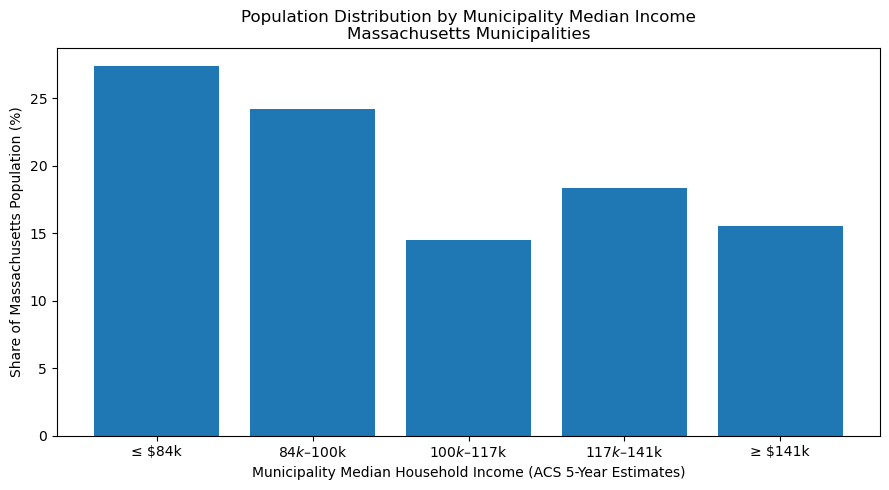

In [15]:
plt.figure(figsize=(9, 5))

plt.bar(
    summary["income_quintile"],
    summary["population_share_pct"]
)

plt.ylabel("Share of Massachusetts Population (%)")
plt.xlabel("Municipality Median Household Income (ACS 5-Year Estimates)")
plt.title(
    "Population Distribution by Municipality Median Income\n"
    "Massachusetts Municipalities"
)

plt.xticks(
    ticks=range(len(summary)),
    labels=[
        "≤ $84k",
        "$84k–$100k",
        "$100k–$117k",
        "$117k–$141k",
        "≥ $141k"
    ]
)

plt.tight_layout()
plt.show()


## Results

Figure 1 shows the distribution of the Massachusetts population across municipalities grouped by median household income using ACS 5-year estimates. Municipalities with median household incomes below $100,000 account for just over half of the state’s population, despite representing a similar number of municipalities as higher-income groups.

Population is not evenly distributed across income categories: lower-income municipalities tend to be more populous on average, while higher-income municipalities are more numerous but smaller in population. This pattern highlights how population-weighted analyses can yield different conclusions than municipality-count comparisons alone.


## Methods

Municipality-level median household income and population estimates were drawn from the American Community Survey 2023 5-year estimates. Municipalities were grouped into income quintiles based on median household income, and population shares were calculated using total municipal population counts. Analysis is descriptive and intended to illustrate distributional patterns rather than causal relationships.
